## **0.TIPS**
  **标准的GAN训练循环有3个步骤。**
  <i>
  * （1）用真实的训练数据集训练鉴别器；
  * （2）用生成的数据训练鉴别器；
  * （3）训练生成器生成数据，并使鉴别器以为它是真实数据。
  </i>


## **1.生成1010格式规律**
* *在本节,<u>真实的数据集被替换成了一个函数</u>，会一直生成1010格式规律的数据。*

* *对于这样一个简单的数据源，我们不需要使用PyTorch的torch.utils.data.Dataset对象。*

### 1.1导包

In [6]:
import torch
import torch.nn as nn

import pandas 
import matplotlib.pyplot as plt

import random

### 1.2真实数据源
* 现实生活中很少有如[1,0,1,0]这样如此精确、恒定的数据。
* 所以，让我们给高低值分别添加一些随机性，让这个函数更加真实。要生成随机数，我们需要导入Python的random模块，再使用random.uniform()函数。

In [7]:

def generate_real():
  real_data = torch.FloatTensor(
      [random.uniform(0.8,1.0),
       random.uniform(0.0,0.2),
       random.uniform(0.8,1.0),
       random.uniform(0.0,0.2),
       ]
  )
  return real_data

generate_real()

tensor([0.9061, 0.1934, 0.8836, 0.0192])

### 1.3构建鉴别器
* 我们先编辑鉴别器。跟之前一样，它是一个继承自nn.Module的神经网络。我们按照PyTorch所需要的方式初始化网络，并创建一个forward()函数。
* 我们可以看到训练函数的标准流程。首先，神经网络根据输入值计算输出值。损失值是通过比较输出值和目标值计算得到的。网络中的梯度由这个损失值计算得到，再通过优化器逐步更新可学习参数。

In [8]:
class Discriminator(nn.Module):
  def __init__(self):
    #初始化Pytorch父类
    super().__init__()

    #定义神经网络层
    '''
      网络本身其实很简单。它在输入层有4个节点，因为输入是由4个值组成的。
    在最后一层，它输出单个值。该值为1表示为真，该值为0则表示为伪。隐藏的中
    间层有3个节点。它的确是一个非常小的网络!
    '''
    self.model = nn.Sequential(
        nn.Linear(4,3),
        nn.Sigmoid(),
        nn.Linear(3,1),
        nn.Sigmoid()
    )

    #创建损失函数
    self.loss_function = nn.MSELoss()

    #创建优化器，使用随机梯度下降算法
    self.optimiser = torch.optim.SGD(self.parameters(),lr=0.01)

    #计数器和进程记录
    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    # 直接运行模型
    return self.model(inputs)
  
  #训练函数train()同样可以重复使用第1章中的代码。
  def train(self, inputs, targets):
    outputs = self.forward(inputs)

    loss = self.loss_function(outputs,targets)

    #每训练10次增加计数器
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    #归零梯度，反向传播，并更新权重
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass
  
  #绘制损失值变化
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',
            grid=True,yticks=(0,0.25,0.5))
    pass

  #这些代码与我们的MNIST分类器相似，这并不令人意外。
  #鉴别器本来就是一个分类器，只是层数较少，且只有一个输出值。

## 1.4测试鉴别器
* *在任何机器学习架构中，对重要组件的测试都是很必要的。我们先来测试鉴别器。*
* *由于还没有创建生成器，因此我们无法真正测试与之竞争的鉴别器。**目前能做的是，检验鉴别器是否能将真实数据与随机数据区分开。这听起来似乎没有什么用，不过它的确有效。它可以告诉我们，鉴别器至少有能力从随机数据中区分出真实数据。**如果它做不到这一点，那么它也不太可能完成更艰巨的区分真实数据与看似真实的假数据的任务。所以，这个测试可以筛选出不太可能与生成器竞争的鉴别器。*

In [9]:
#创建一个函数来生成随机噪声(生成任何大小的张量)
def generate_random(size):
  random_data = torch.rand(size)  #rand:0-1均匀分布
  return random_data

#开始测试
D = Discriminator()

for i in range(10000):
  #真实数据
  D.train(generate_real(), torch.FloatTensor([1.0]))
  #随机数据
  D.train(generate_random(4), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000


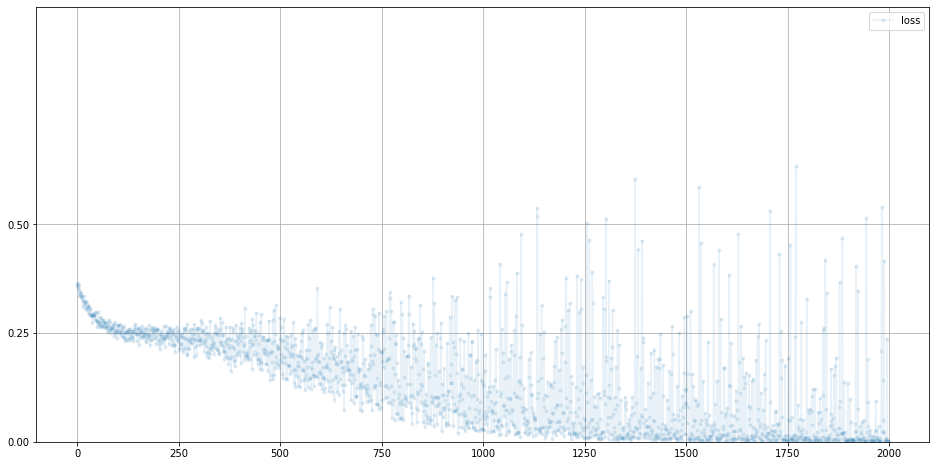

In [10]:
D.plot_progress()

In [11]:
#给训练后的鉴别器输入一些样本,测试训练的效果

#item函数:得到长度为1的张量中的值
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())


0.7932868003845215
0.18509618937969208


* **回顾一下到目前为止的进度。我们无法证明鉴别器可以与生成器有效地竞争。**

* **但能证明的是，<u>鉴别器至少能学会从真实数据集和随机噪声中进行分辨。</u>如果做不到这一点，我们就更不能指望它能与生成器竞争了。**

## 1.5构建生成器
1. 生成器是一个神经网络，而不是一个简单的函数，因为我们希望让它学习。**我们希望它的输出能骗过鉴别器。这意味着输出层需要有4个节点，对应实际数据格式。**
2. 生成器的隐藏层应该有多大? 输入层呢? 我们不需要局限于一个特定的大小，不过这个大小应该足以学习。但也不要太大，因为训练很大的网络需要花很长时间。同时，我们需要配合鉴别器的学习速度。因为我们不希望生成器和鉴别器中的任何一个领先另一个太多。基于这些考量，许多人<u>**从复制鉴别器的构造入手来设计生成器。**</u>
3. 让我们尝试设计一个生成器吧。它的输入层有1个节点，隐含层有3个节点，输出层有4个节点。<u>这就是一个反向鉴别器。</u>
4. 跟所有的神经网络一样，生成器也需要输入。生成器的输入应该是什么呢?我们先从最简单的方案做起，即输入一个常数值。我们知道，太大的值会增加训练的难度，而标准化数据会有所帮助。我们暂时设输入值为0.5，如果遇到问题，可以回来修改。
5. 我们从定义一个生成器类Generator开始，可以直接复制鉴别器类Discriminator的代码并加以修改。**具体而言，生成器不再需要loss_function，且训练函数与鉴别器有所不同**

In [12]:
class Generator(nn.Module):
  def __init__(self):
    #初始化Pytorch父类
    super().__init__()

    #定义神经网络层
    '''
      网络本身其实很简单。它在输入层有4个节点，因为输入是由4个值组成的。
    在最后一层，它输出单个值。该值为1表示为真，该值为0则表示为伪。隐藏的中
    间层有3个节点。它的确是一个非常小的网络!
    '''
    self.model = nn.Sequential(
        nn.Linear(1,3),
        nn.Sigmoid(),
        nn.Linear(3,4),
        nn.Sigmoid()
    )

    #创建优化器，使用随机梯度下降算法
    self.optimiser = torch.optim.SGD(self.parameters(),lr=0.01)

    #计数器和进程记录
    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    # 直接运行模型
    return self.model(inputs)
  
  #训练函数train()同样可以重复使用第1章中的代码。
  def train(self, D, inputs, targets):
    g_output = self.forward(inputs)

    #输入鉴别器
    d_output = D.forward(g_output)
    
    #计算损失值
    loss = D.loss_function(d_output,targets)

    #每训练10次增加计数器
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
        
    #归零梯度，反向传播，并更新权重
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass
  
  #绘制损失值变化
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',
            grid=True,yticks=(0,0.25,0.5))
    pass

  

1. 这段代码很容易理解。首先，self.forward(inputs)将输入值inputs传递给生成器自身的神经网络。接着，通过D.forward(g_output)将生成器网络的输出g_ouput传递给鉴别器的神经网络，并输出分类结果d_output。
2. *鉴别器损失值由这个d_output和训练目标targets变量计算得出。误差梯度的反向传播由这个损失值触发，在计算图中经过鉴别器回到生成器。*
3. **更新由self.optimiser而不是D.optimiser触发。这样一来，只有生成器的链接权重得到更新，这正是GAN训练循环第3步的目的。**
4. 有Python使用经验的读者可能会问，将整个复杂的discriminator对象传递给生成器的train()函数有没有问题？其实不必担心，**因为Python没有传递单独的副本，它传递的只是对同一对象的引用。**这样不仅高效，而且允许我们在生成器中对该对象进行更改，并可以反向传递误差梯度。如果读者看不懂这个问题也不要担心。对于有Python经验的读者，希望这些解释可以解答你的疑问。
5. 我们还删除了生成器里train()函数中的计数打印语句，改为在鉴别器的train()中打印。这样可以通过真实的训练数据更准确地反映训练进度。

## 1.6检查生成器输出
* 在训练生成器之前，让我们检查一下它的输出是否符合要求。
* 在一个新的单元格中，运行以下代码来创建一个新的生成器对象，并输入一个值为0.5的单值张量。

In [13]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))

#可以看到，生成器的输出有4个值，符合我们的要求
#然而，该结果不符合1010格式规律，因为生成器还没有经过训练。

tensor([0.4261, 0.5507, 0.4755, 0.5032], grad_fn=<SigmoidBackward0>)

## 1.7训练GAN
1. **第1步，我们用真实的数据训练鉴别器。**
2. **第2步，我们使用一组生成数据来训练鉴别器。对于生成器输出，detach()的作用是将其从计算图中分离出来。**
  * **<u>通常，对鉴别器损失直接调用backwards()函数会计算整个计算图路径的所有误差梯度。这个路径从鉴别器损失开始，经过鉴别器本身，最后返回生成器。</u>**由于我们只希望训练鉴器，因此不需要计算生成器的梯度。生成器的detach()可以在该点切断计算图。

  * 为什么要这么做呢？ 即使不这样做，照常计算生成器中的梯度，应该也不会有什么坏处吧? 的确，在我们这个简单的网络中，切断计算图的好处不是很明显。但是，对于更大的网络，这么做可以明显地节省计算成本。
3. **第3步，我们输入鉴别器对象和单值0.5训练生成器。这里没有使用detach()，是因为我们希望误差梯度从鉴别器损失传回生成器。生成器的train()函数只更新生成器的链接权重，因此我们不需要防止鉴别器被更新。**

  * 由于训练GAN需要的时间可能比较长，因此在单元格的顶部加入%%time指
令可以帮助我们统计训练所需时间，在进行多个实验的时候尤其有用。

  * 尝试运行代码。对我们这个简单网络来说，训练需要16秒左右。


In [15]:
%%time

#创建鉴别器和生成器

D = Discriminator()
G = Generator()

#训练鉴别器和生成器

#看看1010格式规律在生成器训练过程中是如何演变的。
image_list = []
for i in range(10000):

  #1.用真实样本训练鉴别器
  D.train(generate_real(), torch.FloatTensor([1.0]))

  #2.用生成样本训练鉴别器
  #使用detach()以避免计算生成器G中的梯度（节省计算成本）
  D.train(G.forward(torch.FloatTensor([0.5])).detach(), 
      torch.FloatTensor([0.0]))
  
  #训练生成器
  G.train(D, torch.FloatTensor([0.5]), 
      torch.FloatTensor([1.0]))
  
  #每1000次训练循环记录一次生成器的输出
  if (i % 1000 == 0):
    image_list.append(G.forward(torch.FloatTensor([0.5]))
             .detach().numpy())
  #为了将生成器的输出张量以numpy数组的形式保存，我们需要在使用numpy()之前使用detach()将输出张量从计算图中分离出来。

counter =  10000
counter =  20000


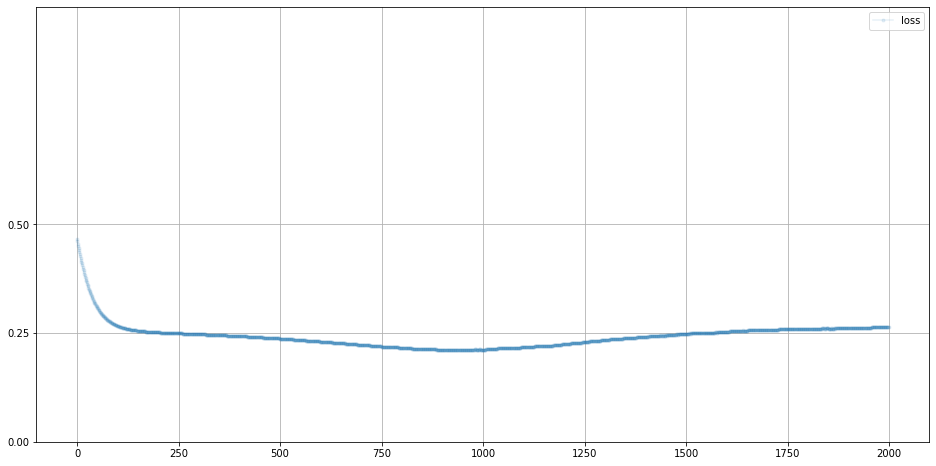

In [19]:
D.plot_progress()



1. *<u>当鉴别器不擅长从伪造数据中识别真实数据时，它就无法确定输出0.0还是1.0，索性就输出0.5。</u>因为我们使用了均方误差，所以损失值的结果是0.5的平方，也就是0.25。*
2. *在这里，随着训练的进行，损失值略有下降，但幅度并不大。这说明网络有了一些进步。目前还不清楚，它是在识别真实的1010格式规律方面做得更好，还是在识别生成的伪造数据方面做得更好，或者两方面都很出色。在训练的后期，损失值回升到0.25。这是一个好现象，说明生成器已经学会生成1010格式的数据，从而使鉴别器无法区分。*
3. *换句话说，鉴别器的输出是0.5，介于0～1。这也正是损失值反弹到0.25的原因。*


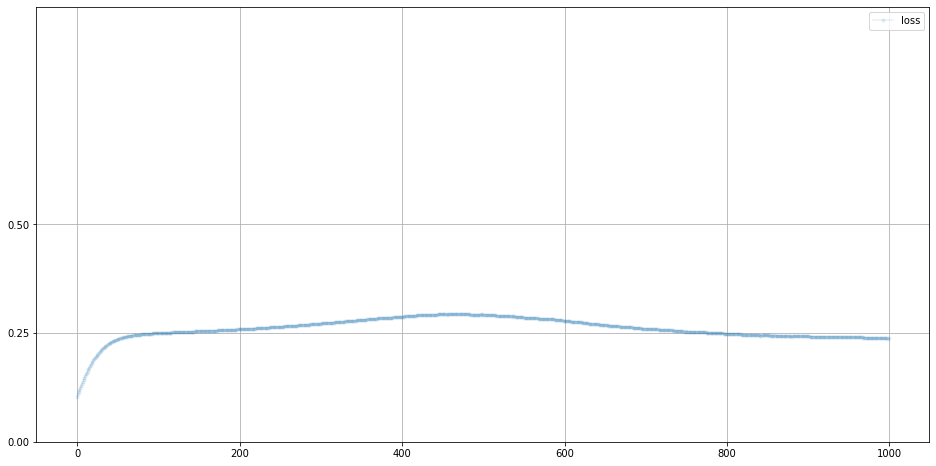

In [20]:
G.plot_progress()

In [21]:
#试验一下训练后的生成器
G.forward(torch.FloatTensor([0.5]))

tensor([0.9411, 0.0533, 0.9049, 0.0563], grad_fn=<SigmoidBackward0>)

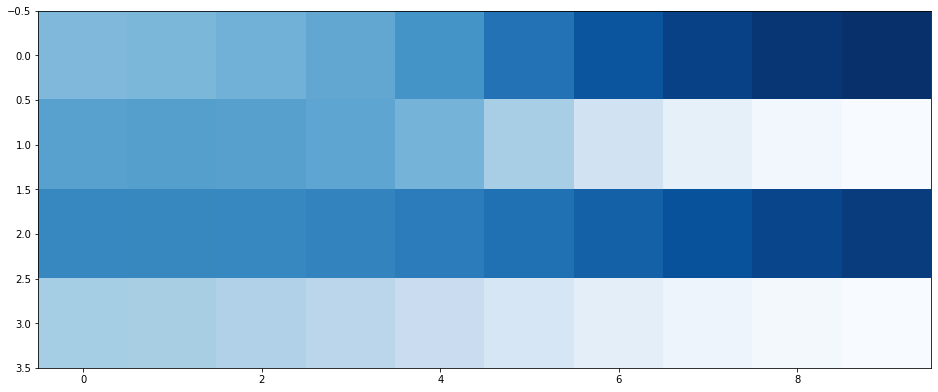

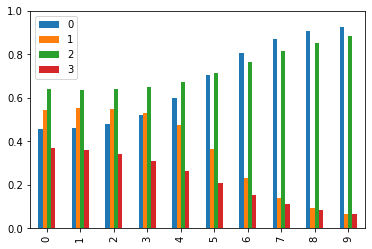

In [47]:
import numpy
import pandas
# print(numpy.array(image_list))
plt.figure(figsize = (16,8))

#可以看出生成器的输出逐渐接近1010

#使用plt.show绘制的热图（数值大小决定颜色的深浅，数值范围0-1）
plt.imshow(numpy.array(image_list).T, interpolation='none', 
            cmap = 'Blues')

#使用dataframe.plot绘制的条形图
pandas.DataFrame(image_list).plot(kind = 'bar', ylim=(0,1))